## About this Notebook

In this kernel, I work on the Health Authority feedback dataset and trying to predict sentiments from the feedbacks. 



In [147]:
# python libraries to read & plot data
import pandas as pd
import numpy as np
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# sklearn libraries for prediction and evaluation
from sklearn import model_selection, preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from xgboost.sklearn import XGBClassifier

# imblearn for balancing dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline,make_pipeline

# nltk for text processing
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup

# Remove Special Charactors
import re

In [2]:
df = pd.read_excel(r"C:\Users\kvbt565\Documents\Python Notebooks\EPAR Usecase\Assignment\sentences_with_sentiment.xlsx")
df.head()

,ID,Sentence,Positive,Negative,Neutral
0,1,The results in 2nd line treatment show an ORR ...,1,0,0
1,2,The long duration of response and high durable...,1,0,0
2,3,The median OS time in the updated results exce...,0,0,1
3,4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
4,5,"The data provided in 1st line, although prelim...",1,0,0


In [3]:
print("Total records in the the dataset: ", len(df))
print("Single rating per sentence :", (df.iloc[:,2:5].sum(axis=1) == 1).all())

Total records in the the dataset:  266
Single rating per sentence : True


In [4]:
# Percentage of Positive/Negative/Neutral
print("Positive: ", df.Positive.value_counts()[1]/len(df)*100,"%")
print("Neutral: ", df.Neutral.value_counts()[1]/len(df)*100,"%")
print("Negative: ", df.Negative.value_counts()[1]/len(df)*100,"%")

Positive:  60.150375939849624 %
Neutral:  26.31578947368421 %
Negative:  13.533834586466165 %


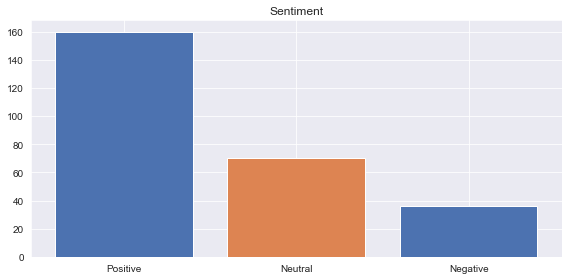

In [5]:
colors = sns.color_palette('deep')

plt.figure(figsize=(8,4), tight_layout=True)
plt.bar(x=['Positive', 'Neutral','Negative'],
        height=[df['Positive'].sum(),df['Neutral'].sum(),df['Negative'].sum()],
        color=colors[:2])
plt.title('Sentiment')
plt.savefig('sentiment.png')
plt.show()

## Data Preprocessing

In [194]:
feedback_data = df.copy()

In [195]:
# Stemmer to update the root word
#porter=PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Stopwords except 'from'
all_stopwords = stopwords.words('english')
#all_stopwords.extend(['the' , 'to' , 'it' , 'i' , 't'])


REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    text = ' '.join([lemmatizer.lemmatize(word,'v') for word in text.split()]) # Use lemmatizer to identify root word
    return text

In [196]:
feedback_data['Sentence'] = feedback_data['Sentence'].apply(clean_text)

In [198]:
feedback_data.head()

,ID,Sentence,Positive,Negative,Neutral,sentence_length,rating
0,1,result 2nd line treatment show orr 33 patients...,1,0,0,133,0
1,2,long duration response high durable response r...,1,0,0,170,0
2,3,median os time update result exceed 1 year,0,0,1,57,1
3,4,therefore clinical benefit 2nd line treatment ...,1,0,0,161,0
4,5,data provide 1st line although preliminary sho...,1,0,0,247,0


In [197]:
feedback_data['rating'] = 0*feedback_data['Positive'] + 1*feedback_data['Neutral'] + 2*feedback_data['Negative']

In [199]:
# Separate the Dataset into feature & target dataframes
X = feedback_data['Sentence']
Y = feedback_data['rating']

## Split Test and Train Data

In [200]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.15, random_state=7)

In [201]:
print("Count of positive class in trainig data set :" ,(sum(y_train==1)))
print("Count of neutral class in trainig data set :",format(sum(y_train==0)))
print("Count of negative class in trainig data set :",format(sum(y_train==-1)))

Count of positive class in trainig data set : 61
Count of neutral class in trainig data set : 136
Count of negative class in trainig data set : 0


In [202]:
print("Count of positive class in testing data set :" ,(sum(y_test==1)))
print("Count of neutral class in testing data set :",format(sum(y_test==0)))
print("Count of negative class in testing data set :",format(sum(y_test==0)))

Count of positive class in testing data set : 9
Count of neutral class in testing data set : 24
Count of negative class in testing data set : 24


In [204]:
# Run this cell only if we need to download the test dataset
test = x_test.to_frame().reset_index()
test.drop('index',axis=1,inplace=True)
#test.to_csv(r'test_x.csv',index=False)
test.head()

,Sentence
0,additional sensitivity analyse perform confirm...
1,rmp adequately reflect safety concern list two...
2,median os time update result exceed 1 year
3,major contribution hba1c due insulin glargine ...
4,clinical safety section smpc contain appropria...


In [169]:
pd.DataFrame(y_test).to_csv("test_y.csv",index=None,header=None)

In [203]:
x_test

89     additional sensitivity analyse perform confirm...
226    rmp adequately reflect safety concern list two...
2             median os time update result exceed 1 year
209    major contribution hba1c due insulin glargine ...
251    clinical safety section smpc contain appropria...
70     regard immunogenicity differences aia response...
113    maintenance treatment effect year 3 4 support ...
22     addition pk data discuss support extrapolation...
66     study demonstrate sar342434 noninferior humalo...
114    clinically relevant add benefit additional tre...
253    clinical data assess nuwiq application adequat...
166    since rolufta application inform consent incru...
126    appropriately cover maviret smpc addition cont...
184    current study provide evidence treatment effec...
216               lack longterm data beyond 30 weeks frc
239    tdi focal score third coprimary endpoint clini...
125    risk alt elevations seem lower compare previou...
129    concern raise procedure 

## Vectorization

In [83]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
xtrain_tfidf =  tfidf_vect.fit_transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

In [84]:
print('Tfidf_train:',xtrain_tfidf.shape)
print('Tfidf_test:',xtest_tfidf.shape)

Tfidf_train: (226, 1091)
Tfidf_test: (40, 1091)


## Balancing Dataset & Model selection

In [98]:
# Return the F1 Score
def train_model(classifier, vector_train, tgt, vector_test,alg_name):    
    classifier.fit(vector_train, tgt)    
    predictions = classifier.predict(vector_test)
    print("****************************************************************")
    print("F1 Score of "+ alg_name + " Baseline, Wordlevel TFIDF:", metrics.f1_score(y_test,predictions,average='weighted')) 
    return classification_report(y_test,predictions)

In [107]:
# Logistic Regression
Pred = train_model(LogisticRegression(random_state=0,multi_class='multinomial',n_jobs=1, C=1e5),xtrain_tfidf, y_train, xtest_tfidf,'LR')
print ("LR Classification Report: ", Pred)

# Support Vector classification
Pred = train_model(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None), xtrain_tfidf, y_train, xtest_tfidf,'SGD')
print ("SGD Classification Report: ", Pred)

# Decision Tree classifier
Pred = train_model(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf,'NB')
print ("NB Classification Report: ", Pred)

Pred = train_model(KNeighborsClassifier(n_neighbors=10),xtrain_tfidf, y_train, xtest_tfidf,'KNN')
print ("KNN Baseline, WordLevel TFIDF: ", Pred)

Pred = train_model(RandomForestClassifier(n_jobs=None,random_state=27,verbose=1),xtrain_tfidf, y_train, xtest_tfidf,'RF')
print ("RF Baseline, WordLevel TFIDF: ", Pred)

Pred = train_model(XGBClassifier(learning_rate=0.1,n_estimators = 100,objective='multi:softmax'),xtrain_tfidf, y_train, xtest_tfidf,'XGB')
print ("XGB Baseline, WordLevel TFIDF: ", Pred) 



****************************************************************
F1 Score of LR Baseline, Wordlevel TFIDF: 0.5871428571428571
LR Classification Report:                precision    recall  f1-score   support

           0       0.66      0.88      0.75        24
           1       0.20      0.11      0.14         9
           2       1.00      0.43      0.60         7

    accuracy                           0.62        40
   macro avg       0.62      0.47      0.50        40
weighted avg       0.61      0.62      0.59        40

****************************************************************
F1 Score of SGD Baseline, Wordlevel TFIDF: 0.5871428571428571
SGD Classification Report:                precision    recall  f1-score   support

           0       0.66      0.88      0.75        24
           1       0.20      0.11      0.14         9
           2       1.00      0.43      0.60         7

    accuracy                           0.62        40
   macro avg       0.62      0.47      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

****************************************************************
F1 Score of RF Baseline, Wordlevel TFIDF: 0.5949089253187614
RF Baseline, WordLevel TFIDF:                precision    recall  f1-score   support

           0       0.65      1.00      0.79        24
           1       1.00      0.11      0.20         9
           2       1.00      0.29      0.44         7

    accuracy                           0.68        40
   macro avg       0.88      0.47      0.48        40
weighted avg       0.79      0.68      0.59        40

[15:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****************************************************************
F1 Score of XGB Baseline, Wordlevel TFIDF: 0.5922095959595959
XGB Baseline, WordLevel 

In [106]:
# Random Over Sampling
ros = RandomOverSampler(random_state=777)
ros_xtrain_tfidf, ros_train_y = ros.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
ros = train_model(LogisticRegression(random_state=0,multi_class='multinomial',n_jobs=1, C=1e5),ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'LR')
print ("LR Classification Report: ", ros)

# Support Vector classification
ros = train_model(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None), ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'SGD')
print ("SGD Classification Report: ", ros)

# Decision Tree classifier
ros = train_model(MultinomialNB(), ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'NB')
print ("NB Classification Report: ", ros)

ros = train_model(KNeighborsClassifier(n_neighbors=10),ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'KNN')
print ("KNN Baseline, WordLevel TFIDF: ", ros)

ros = train_model(RandomForestClassifier(n_jobs=None,random_state=27,verbose=1),ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'RF')
print ("RF Baseline, WordLevel TFIDF: ", ros)

ros = train_model(XGBClassifier(learning_rate=0.1,n_estimators = 100,objective='multi:softmax',use_label_encoder =False),ros_xtrain_tfidf, ros_train_y, xtest_tfidf,'XGB')
print ("XGB Baseline, WordLevel TFIDF: ", ros) 

****************************************************************
F1 Score of LR Baseline, Wordlevel TFIDF: 0.5957792207792207
LR Classification Report:                precision    recall  f1-score   support

           0       0.65      0.83      0.73        24
           1       0.20      0.11      0.14         9
           2       1.00      0.57      0.73         7

    accuracy                           0.62        40
   macro avg       0.62      0.51      0.53        40
weighted avg       0.61      0.62      0.60        40

****************************************************************
F1 Score of SGD Baseline, Wordlevel TFIDF: 0.6317171717171717
SGD Classification Report:                precision    recall  f1-score   support

           0       0.67      0.83      0.74        24
           1       0.33      0.22      0.27         9
           2       1.00      0.57      0.73         7

    accuracy                           0.65        40
   macro avg       0.67      0.54      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


****************************************************************
F1 Score of RF Baseline, Wordlevel TFIDF: 0.6373642439431914
RF Baseline, WordLevel TFIDF:                precision    recall  f1-score   support

           0       0.67      0.92      0.77        24
           1       0.60      0.33      0.43         9
           2       1.00      0.29      0.44         7

    accuracy                           0.68        40
   macro avg       0.76      0.51      0.55        40
weighted avg       0.71      0.68      0.64        40

[15:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****************************************************************
F1 Score of XGB Baseline, Wordlevel TFIDF: 0.6056079664570231
XGB Baseline, WordLevel 

In [105]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=777)
rus_xtrain_tfidf, rus_train_y = rus.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
rus = train_model(LogisticRegression(random_state=0,multi_class='multinomial',n_jobs=1, C=1e5),rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'LR')
print ("LR Classification Report: ", rus)

# Support Vector classification
rus = train_model(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None), rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'SGD')
print ("SGD Classification Report: ", rus)

# Decision Tree classifier
rus = train_model(MultinomialNB(), rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'NB')
print ("NB Classification Report: ", rus)

rus = train_model(KNeighborsClassifier(n_neighbors=10),rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'KNN')
print ("KNN Baseline, WordLevel TFIDF: ", rus)

rus = train_model(RandomForestClassifier(n_jobs=None,random_state=27,verbose=1),rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'RF')
print ("RF Baseline, WordLevel TFIDF: ", rus)

rus = train_model(XGBClassifier(learning_rate=0.1,n_estimators = 100,objective='multi:softmax',use_label_encoder =False),rus_xtrain_tfidf, rus_train_y, xtest_tfidf,'XGB')
print ("XGB Baseline, WordLevel TFIDF: ", rus) 

****************************************************************
F1 Score of LR Baseline, Wordlevel TFIDF: 0.6092348608837971
LR Classification Report:                precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.27      0.33      0.30         9
           2       0.67      0.57      0.62         7

    accuracy                           0.60        40
   macro avg       0.56      0.54      0.55        40
weighted avg       0.62      0.60      0.61        40

****************************************************************
F1 Score of SGD Baseline, Wordlevel TFIDF: 0.5963587296620776
SGD Classification Report:                precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.25      0.22      0.24         9
           2       0.56      0.71      0.63         7

    accuracy                           0.60        40
   macro avg       0.51      0.55      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



****************************************************************
F1 Score of XGB Baseline, Wordlevel TFIDF: 0.47085576923076927
XGB Baseline, WordLevel TFIDF:                precision    recall  f1-score   support

           0       0.80      0.50      0.62        24
           1       0.12      0.22      0.16         9
           2       0.33      0.43      0.38         7

    accuracy                           0.42        40
   macro avg       0.42      0.38      0.38        40
weighted avg       0.57      0.42      0.47        40



In [104]:
# SMOTE(Synthetic Minority Oversampling Technique)
smote = SMOTE(k_neighbors = 3, random_state=1)   
smot_train_tfidf, smot_train_y = smote.fit_resample(xtrain_tfidf, y_train)

# Logistic Regression
smot = train_model(LogisticRegression(random_state=0,multi_class='multinomial',n_jobs=1, C=1e5),smot_train_tfidf, smot_train_y, xtest_tfidf,'LR')
print ("LR Classification Report: ", smot)

# Support Vector classification
smot = train_model(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None), smot_train_tfidf, smot_train_y, xtest_tfidf,'SGD')
print ("SGD Classification Report: ", smot)

# Decision Tree classifier
smot = train_model(MultinomialNB(), smot_train_tfidf, smot_train_y, xtest_tfidf,'NB')
print ("NB Classification Report: ", smot)

smot = train_model(KNeighborsClassifier(n_neighbors=10),smot_train_tfidf, smot_train_y, xtest_tfidf,'KNN')
print ("KNN Baseline, WordLevel TFIDF: ", smot)

smot = train_model(RandomForestClassifier(n_jobs=None,random_state=27,verbose=1),smot_train_tfidf, smot_train_y, xtest_tfidf,'RF')
print ("RF Baseline, WordLevel TFIDF: ", smot)

smot = train_model(XGBClassifier(learning_rate=0.1,n_estimators = 100,objective='multi:softmax',use_label_encoder =False),smot_train_tfidf, smot_train_y, xtest_tfidf,'XGB')
print ("XGB Baseline, WordLevel TFIDF: ", smot) 

****************************************************************
F1 Score of LR Baseline, Wordlevel TFIDF: 0.5871428571428571
LR Classification Report:                precision    recall  f1-score   support

           0       0.66      0.88      0.75        24
           1       0.20      0.11      0.14         9
           2       1.00      0.43      0.60         7

    accuracy                           0.62        40
   macro avg       0.62      0.47      0.50        40
weighted avg       0.61      0.62      0.59        40

****************************************************************
F1 Score of SGD Baseline, Wordlevel TFIDF: 0.6118881118881119
SGD Classification Report:                precision    recall  f1-score   support

           0       0.66      0.88      0.75        24
           1       0.25      0.11      0.15         9
           2       1.00      0.57      0.73         7

    accuracy                           0.65        40
   macro avg       0.64      0.52      

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


****************************************************************
F1 Score of RF Baseline, Wordlevel TFIDF: 0.6205743879472693
RF Baseline, WordLevel TFIDF:                precision    recall  f1-score   support

           0       0.66      0.96      0.78        24
           1       0.67      0.22      0.33         9
           2       1.00      0.29      0.44         7

    accuracy                           0.68        40
   macro avg       0.77      0.49      0.52        40
weighted avg       0.72      0.68      0.62        40

[15:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
****************************************************************
F1 Score of XGB Baseline, Wordlevel TFIDF: 0.6052213868003341
XGB Baseline, WordLevel 

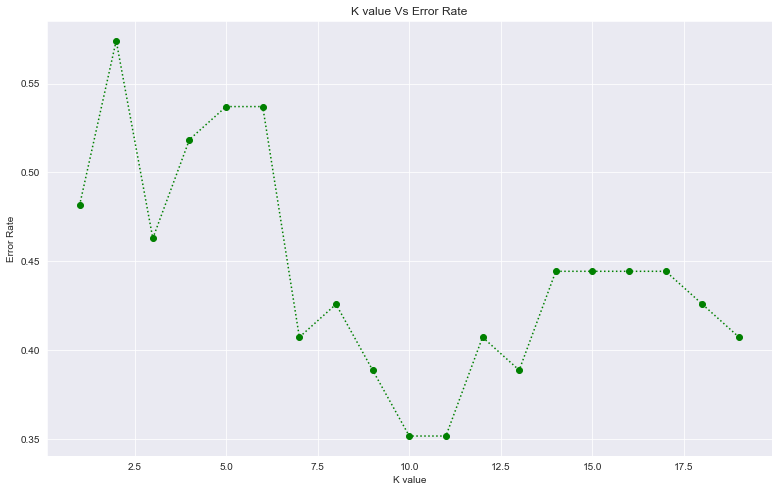

In [104]:
 error_rate=[]
 for i in range(1,20):
     knn = KNeighborsClassifier(n_neighbors=i)
     model = knn.fit(xtrain_tfidf,y_train)
     pred_i = knn.predict(xtest_tfidf)
     error_rate.append(np.mean(pred_i != y_test))
 plt.figure(figsize=(13,8))
 plt.plot(range(1,20), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
 plt.xlabel('K value')
 plt.ylabel('Error Rate')
 plt.title('K value Vs Error Rate')
 plt.show() 


## Hyperparameter Tuning

In [108]:
# Set the parameters
params = {'n_estimators':range(100,500,50),'max_depth':[8, 9, 10, 11, 12],'max_features':['auto'],'criterion' :['gini']}

# Run Grid Search against different input Parameters
rf = RandomForestClassifier(n_jobs=None,random_state=27,verbose=1)
rf_grid = model_selection.GridSearchCV(estimator = rf, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
rf_grid.fit(smot_train_tfidf, smot_train_y)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=27, verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [8, 9, 10, 11, 12],
                         'max_features': ['auto'],
                         'n_estimators': range(100, 500, 50)},
             scoring='f1_micro', verbose=10)

In [109]:
# Grid Search gives the best parameters for the model 
print(rf_grid.best_params_)
print(rf_grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
RandomForestClassifier(max_depth=10, random_state=27, verbose=1)


## Final Model

In [181]:
# Identified algorithms with their parameters
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
smote = SMOTE(k_neighbors = 3, random_state=1)   
rf = RandomForestClassifier(random_state=27,verbose=1,n_jobs=None)

In [182]:
# Create an imblearn pipeline
pipe = make_pipeline(tfidf,smote, rf)

In [183]:
# Fit the data against the pipeline
model = pipe.fit(x_train, y_train)
model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=100000, token_pattern='\\w{1,}')),
                ('smote', SMOTE(k_neighbors=3, random_state=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=27, verbose=1))])

In [184]:
# Create the pickle file
pickle.dump(model, open('multi_classifier.pkl', 'wb'))

## Evaluation metrics

In [205]:
# Predicting the pipeline for test features
rf_predict=model.predict(x_test)
print(rf_predict)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [160]:
# Metrics from the pipeline
rf_accuracy=accuracy_score(y_test,rf_predict)
print("RF Accuracy Score :",rf_accuracy)

rf_precision=precision_score(y_test,rf_predict,average='weighted')
print("RF Precision Score :",rf_precision)

rf_recall=recall_score(y_test,rf_predict,average='weighted')
print("RF Recall Score :",rf_recall)

rf_f1=f1_score(y_test,rf_predict,average='weighted')
print("RF F1 Score :",rf_f1)

RF Accuracy Score : 0.675
RF Precision Score : 0.7192857142857143
RF Recall Score : 0.675
RF F1 Score : 0.6205743879472693


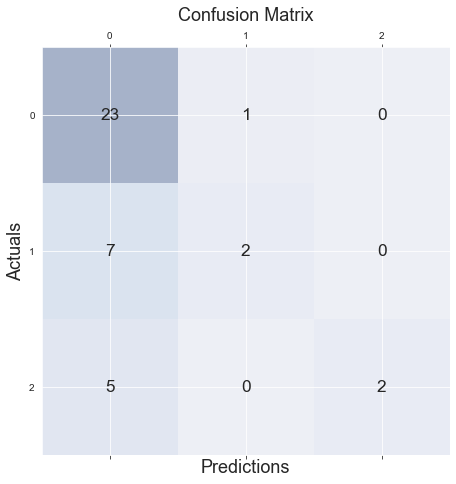

In [161]:
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=rf_predict)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
model